In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
from torch.utils.data import Dataset, DataLoader


In [3]:
#geting data from csv
df = pd.read_csv(r"D:\ML4SCI_CMS\MTAE\higgs\HIGGS.csv\HIGGS.csv", header=None) #header  is none bcz first row is not name it has data


In [4]:
print(df.head())
X = df.iloc[:,1:]  # Selects all columns except the first one
y = df.iloc[:,0]   # Selects only the first column


    0         1         2         3         4         5         6         7   \
0  1.0  0.869293 -0.635082  0.225690  0.327470 -0.689993  0.754202 -0.248573   
1  1.0  0.907542  0.329147  0.359412  1.497970 -0.313010  1.095531 -0.557525   
2  1.0  0.798835  1.470639 -1.635975  0.453773  0.425629  1.104875  1.282322   
3  0.0  1.344385 -0.876626  0.935913  1.992050  0.882454  1.786066 -1.646778   
4  1.0  1.105009  0.321356  1.522401  0.882808 -1.205349  0.681466 -1.070464   

         8         9   ...        19        20        21        22        23  \
0 -1.092064  0.000000  ... -0.010455 -0.045767  3.101961  1.353760  0.979563   
1 -1.588230  2.173076  ... -1.138930 -0.000819  0.000000  0.302220  0.833048   
2  1.381664  0.000000  ...  1.128848  0.900461  0.000000  0.909753  1.108330   
3 -0.942383  0.000000  ... -0.678379 -1.360356  0.000000  0.946652  1.028704   
4 -0.921871  0.000000  ... -0.373566  0.113041  0.000000  0.755856  1.361057   

         24        25        26       

In [5]:

# Get the inputs and outputs
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# get only the first 1mil items
X = X[:1000000]
y = y[:1000000]

print(X.shape)

(1000000, 28)


removing last seven high  level features and adding padding to  seperate
0	Class label (1 = signal, 0 = background)
1-7 	Kinematic properties of particles
8-13	Jet-related features
14-21	Other low-level physics features



In [6]:

# Remove high level features and add 0 padding to line up related quantities
X = np.delete(X, obj=np.s_[X.shape[1]-7:X.shape[1]], axis=-1)
X = np.insert(X, obj=np.s_[3:4], values=0, axis=-1)
X = np.insert(X, obj=np.s_[5:6], values=0, axis=-1)
X = np.insert(X, obj=np.s_[7:8], values=0, axis=-1)

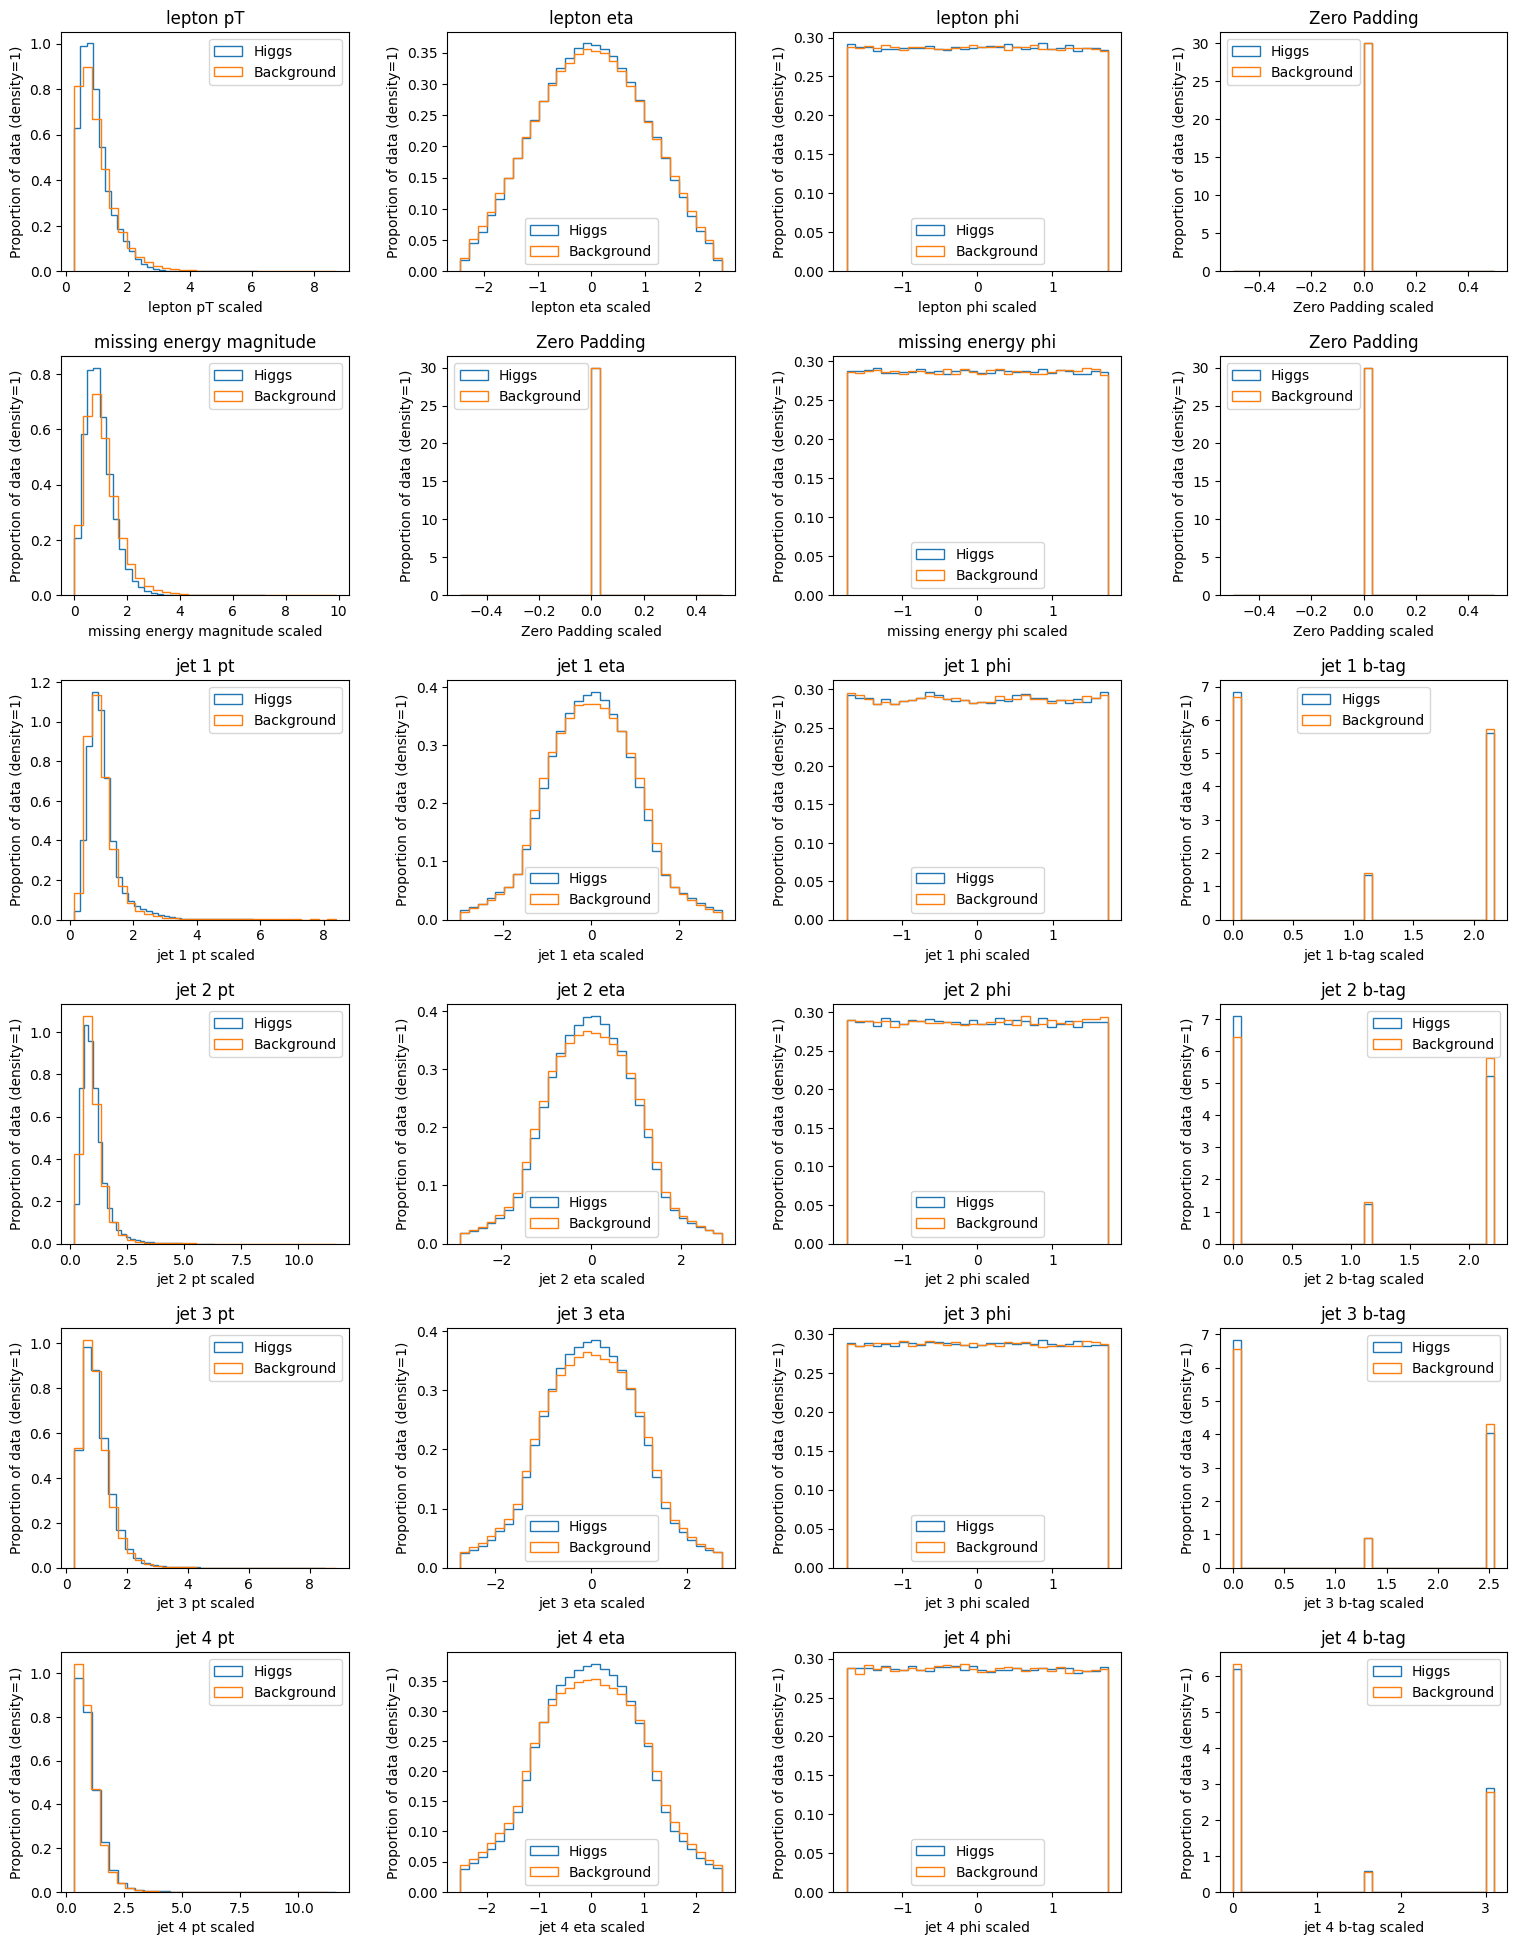

In [7]:
import matplotlib.pyplot as plt

lowlevel_features = ["lepton pT", "lepton eta", "lepton phi", "Zero Padding",
         "missing energy magnitude", "Zero Padding", "missing energy phi", "Zero Padding",
         "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag",
         "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag",
         "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag",
         "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag"]

fig, axes = plt.subplots(6,4, figsize=(16,20))
fig.tight_layout(pad=4)

X_higgs = X[y==1]
X_backnoise = X[y==0]
y_higgs = y[y==1]
y_backnoise = y[y==0]

for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i,j].hist(X_higgs[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Higgs')
        axes[i,j].hist(X_backnoise[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Background')
        axes[i,j].set_title(lowlevel_features[i*4+j])
        axes[i,j].set_xlabel(lowlevel_features[i*4+j] + ' scaled')
        axes[i,j].legend()
        axes[i,j].set_ylabel("Proportion of data (density=1)")
plt.show()

In [8]:
print(len(X_higgs))
print(len(X_backnoise))

529673
470327


In [9]:
# "hh"  for Higgs-Higgs events.

# "tt" Top-Top background events.
hh = np.ones(len(X_higgs))  # label 1 to all Higgs events
tt = np.zeros(len(X_backnoise))  #label 0 to all non-Higgs events


In [10]:
# print(hh.shape)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_hh_train, X_val1, labels_hh_train, labels_val1 = train_test_split(X_higgs, hh, test_size=0.2, random_state=42)
X_hh_val, X_hh_test, labels_hh_val, labels_hh_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)
     

In [11]:
# Normalize data
x_scaler = StandardScaler()
X_hh_train = x_scaler.fit_transform(X_hh_train)
X_hh_val = x_scaler.transform(X_hh_val)
X_hh_test = x_scaler.transform(X_hh_test)
X_nohiggs = x_scaler.transform(X_backnoise)


In [12]:
X_tt_train, X_val1, labels_tt_train, labels_val1 = train_test_split(X_nohiggs, tt, test_size=0.2, random_state=42)
X_tt_val, X_tt_test, labels_tt_val, labels_tt_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)
     

In [13]:
# Now, the data is reshaped into [N, 6, 4], where:

# N: Number of events.

# 6: Number of particles/jets (lepton, missing energy, up to 4 jets).

# 4: Features per particle (e.g., pT, eta, phi, b-tag for jets).

X_hh_train = X_hh_train.reshape(X_hh_train.shape[0], 6, 4)
X_hh_val = X_hh_val.reshape(X_hh_val.shape[0], 6, 4)
X_hh_test = X_hh_test.reshape(X_hh_test.shape[0], 6, 4)

X_tt_train = X_tt_train.reshape(X_tt_train.shape[0], 6, 4)
X_tt_val = X_tt_val.reshape(X_tt_val.shape[0], 6, 4)
X_tt_test = X_tt_test.reshape(X_tt_test.shape[0], 6, 4)

In [14]:
# 0 → Weak b-tagging (low confidence in b-quark presence)

# 1 → Medium b-tagging (uncertain, could be both)

# 2 → Strong b-tagging (high confidence in b-quark presence)
def transformation(data):
    unique_values = np.unique(data)
    value_to_int = {value: i for i, value in enumerate(unique_values)}
    discretized_data = np.vectorize(value_to_int.__getitem__)(data)
    
    new_array = np.zeros((len(discretized_data), 2)) ## Create a Two-Column Encoding
    for i, val in enumerate(discretized_data):
        if val == 0:
            new_array[i] = [1, 0]
        elif val == 1:
            new_array[i] = [0.5, 0.5]
        else:
            new_array[i] = [0, 1]

    return new_array


In [15]:
def expand_and_append(array):
    array = np.append(array, np.zeros((array.shape[0], array.shape[1], 1)), axis=2)
    return array

In [16]:

# Apply b-tag modification to be a 2-class probability 1 -> [0, 1]; 0 -> [1, 0]; .5 -> [.5, .5]
X_hh_train = expand_and_append(X_hh_train)
X_hh_val = expand_and_append(X_hh_val)
X_hh_test = expand_and_append(X_hh_test)
X_tt_train = expand_and_append(X_tt_train)
X_tt_val = expand_and_append(X_tt_val)
X_tt_test = expand_and_append(X_tt_test)

for i in range(3,len(X_hh_train[0]),5):
    for j in range(6):
        X_hh_train[:,j,i:i+2] = transformation(X_hh_train[:,j,i])
        X_hh_val[:,j,i:i+2] = transformation(X_hh_val[:,j,i])
        X_hh_test[:,j,i:i+2] = transformation(X_hh_test[:,j,i])
        X_tt_train[:,j,i:i+2] = transformation(X_tt_train[:,j,i])
        X_tt_val[:,j,i:i+2] = transformation(X_tt_val[:,j,i])
        X_tt_test[:,j,i:i+2] = transformation(X_tt_test[:,j,i])

In [17]:

print(X_hh_train.shape)

(423738, 6, 5)


In [18]:

# Get weights for soft label focal loss
def compute_class_weights(arr):
    f_alphas = []
    for i in range(arr.shape[1]):
        temp_data = arr[:,i]
        temp_other_data = np.delete(arr, i, 1)
        len_neg = len(temp_data[temp_data == 0])
        pos_data = np.sum(temp_other_data, axis=1)
        len_pos = len(temp_data[temp_data == 1]) - len(temp_other_data[temp_other_data >= 2])/len(temp_other_data)
        f_alphas.append([len_pos/(len_pos+len_neg), len_neg/(len_neg+len_pos)])
    return f_alphas

In [19]:
f_alphas = (compute_class_weights(X_hh_train[:,:,4]))
f_alphas = np.array(f_alphas)
print(f_alphas)


[[0.         1.        ]
 [0.         1.        ]
 [0.45049583 0.54950417]
 [0.42315248 0.57684752]
 [0.37164203 0.62835797]
 [0.3168511  0.6831489 ]]


In [20]:
# can increase or decrease the class wight by multiplying the column  for handling class imbalance

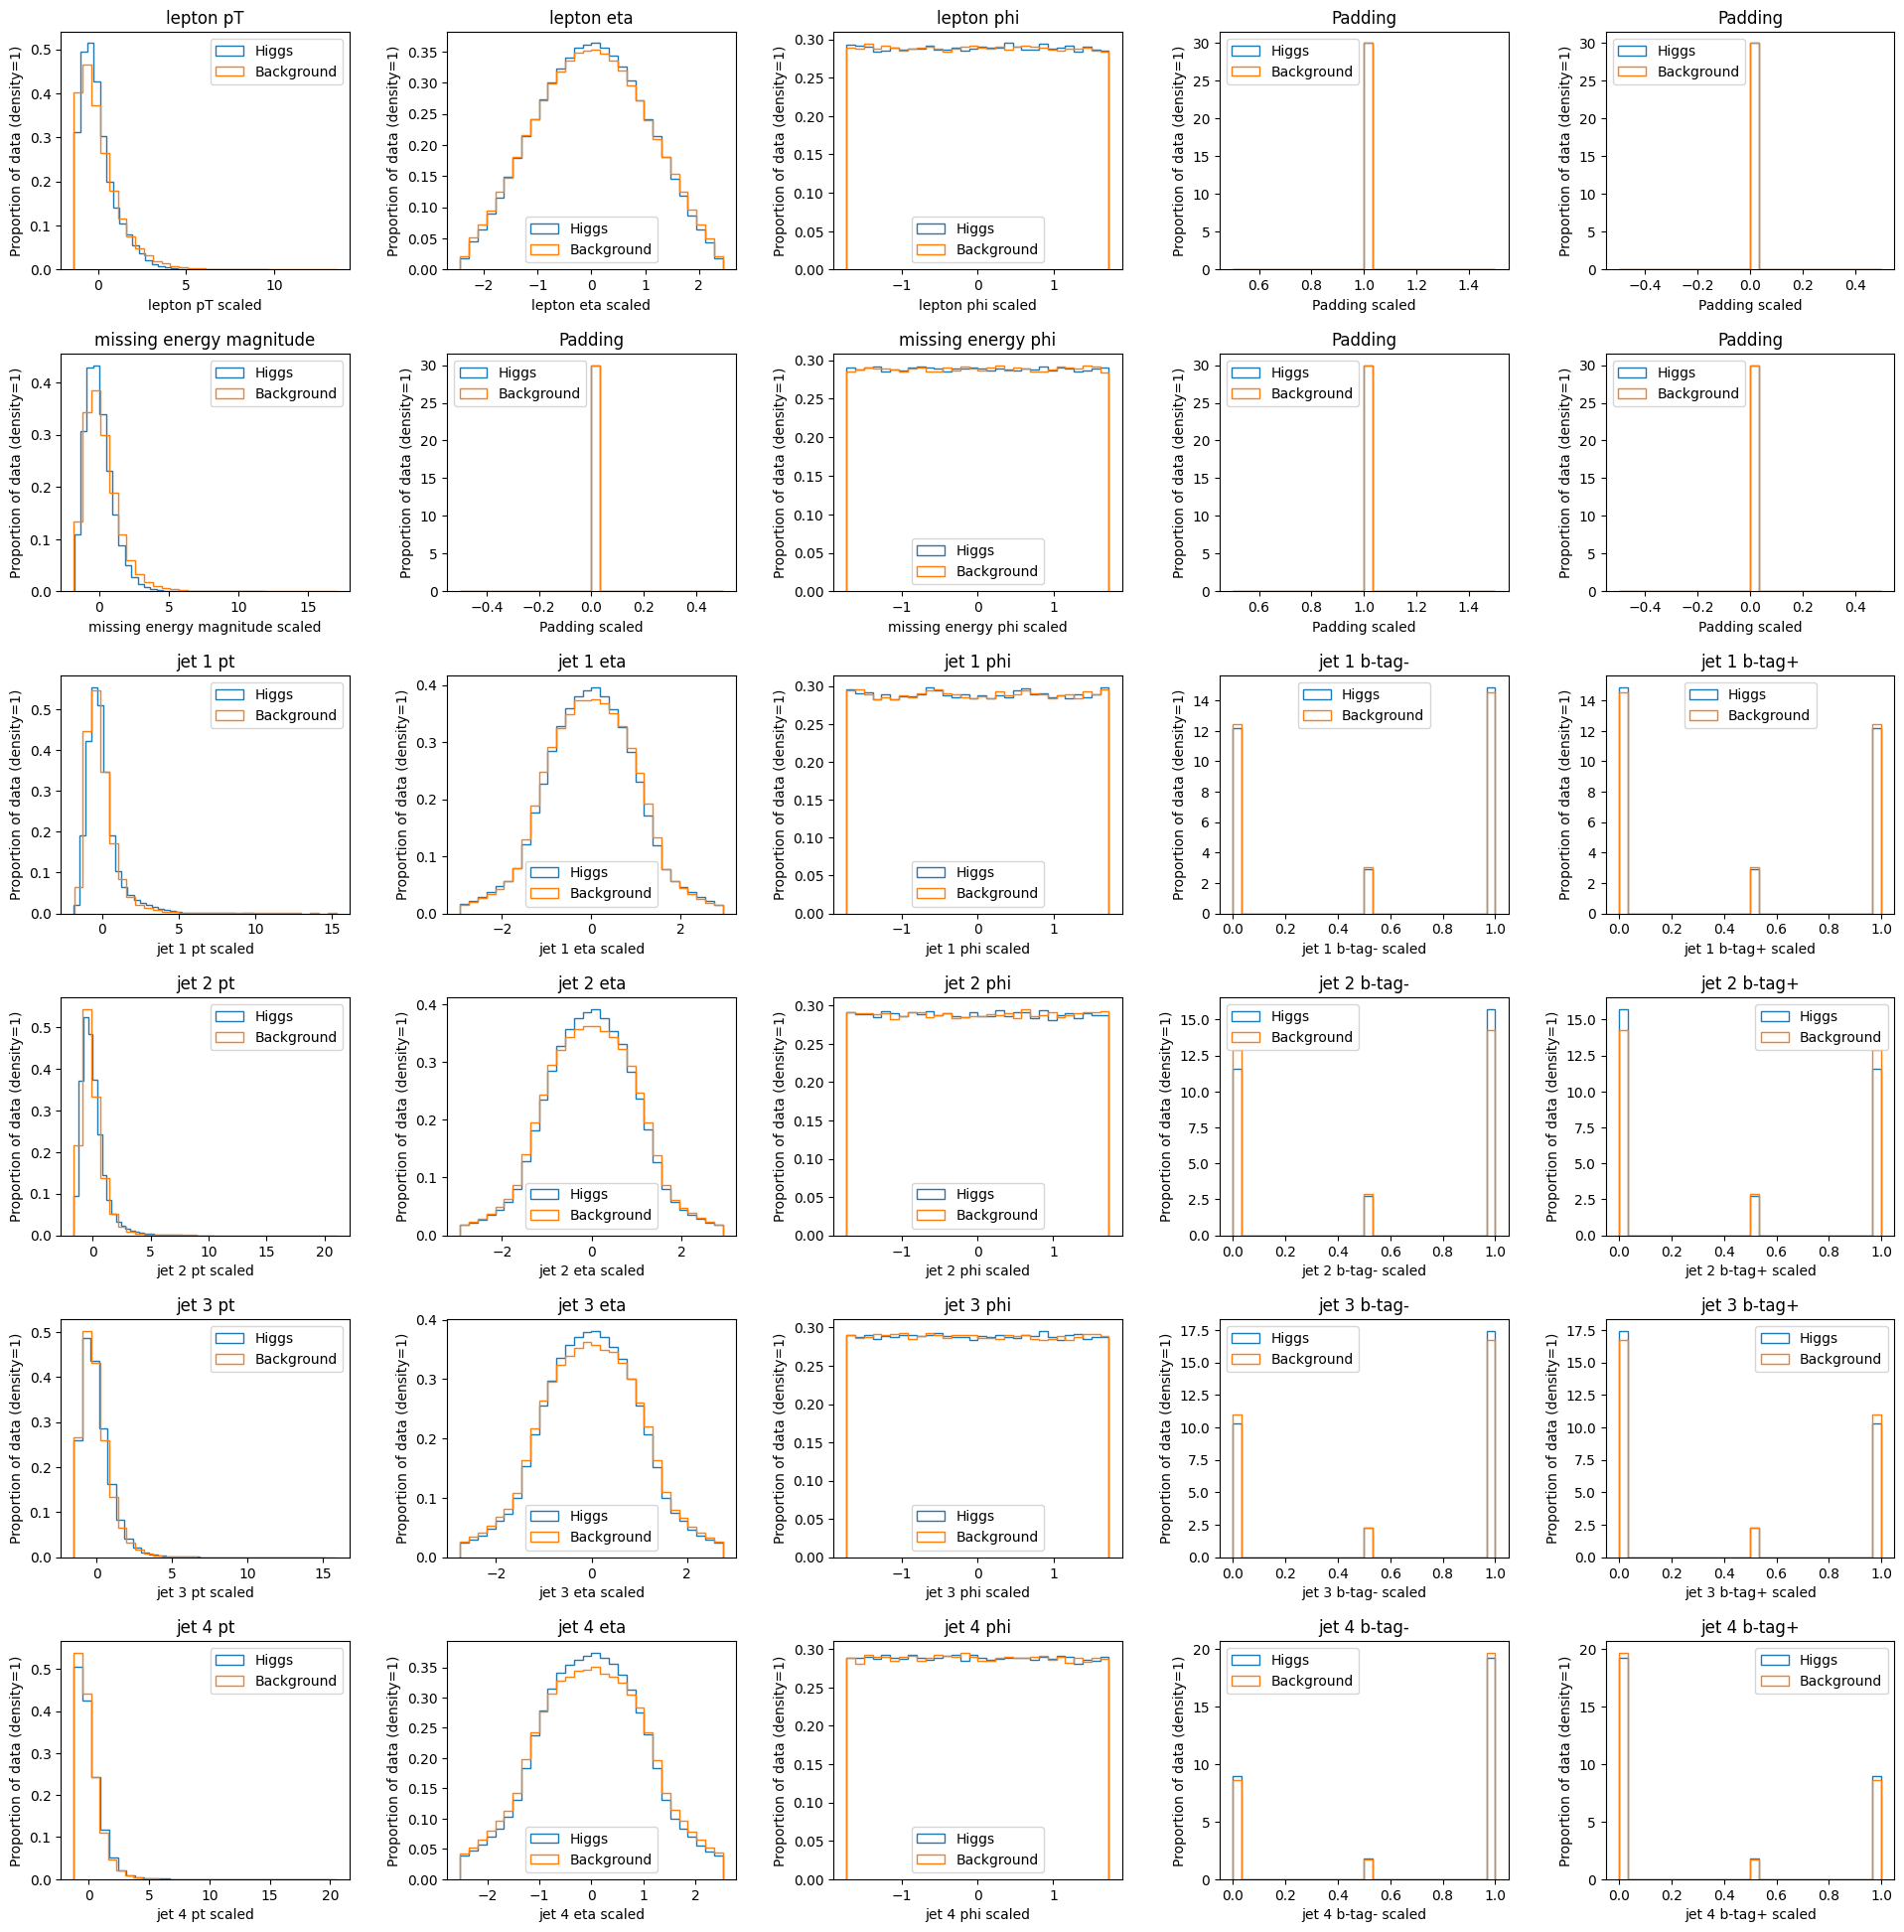

In [21]:
#after all the transformation  lets see our data again

features = ["lepton pT", "lepton eta", "lepton phi", "Padding", "Padding",
         "missing energy magnitude", "Padding", "missing energy phi", "Padding", "Padding",
         "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag-", "jet 1 b-tag+",
         "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag-", "jet 2 b-tag+",
         "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag-", "jet 3 b-tag+",
         "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag-", "jet 4 b-tag+",]

fig, axes = plt.subplots(6,5, figsize=(20,20))
fig.tight_layout(pad=4)

for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i,j].hist(X_hh_train[:,i,j], histtype='step', stacked=False, density=1, bins=30, label='Higgs')
        axes[i,j].hist(X_tt_train[:,i,j], histtype='step', stacked=False, density=1, bins=30, label='Background')
        axes[i,j].set_title(features[i*5+j])
        axes[i,j].set_xlabel(features[i*5+j] + ' scaled')
        axes[i,j].legend()
        axes[i,j].set_ylabel("Proportion of data (density=1)")

In [22]:
#appending the data  and freeing memory 
X_train = np.append(X_hh_train, X_tt_train, axis=0)
del X_tt_train
X_val = np.append(X_hh_val, X_tt_val, axis=0)
del X_tt_val
X_test = np.append(X_hh_test, X_tt_test, axis=0)
del X_tt_test
labels_train = np.append(labels_hh_train, labels_tt_train, axis=0)
del labels_tt_train
labels_val = np.append(labels_hh_val, labels_tt_val, axis=0)
del labels_tt_val
labels_test = np.append(labels_hh_test, labels_tt_test, axis=0)
del labels_tt_test

In [23]:
import json
with open(r"D:\ML4SCI_CMS\MTAE\parameters.json", 'r') as f:
        config = json.load(f)

In [24]:
class CustomActivationFunction(nn.Module):
    def forward(self, x):
        return torch.relu(x + torch.sin(x) ** 2)

class BinaryClassifier(nn.Module):
    def __init__(self, input_size, dim, dropout):
        super(BinaryClassifier, self).__init__()

        self.linear1 = nn.Linear(input_size, dim)

        self.linear2 = nn.Linear(dim, dim)

        self.linear3 = nn.Linear(dim, dim)

        self.linear4 = nn.Linear(dim, dim)

        self.linear5 = nn.Linear(dim, dim)

        self.linear6 = nn.Linear(dim, 1)

        self.custom_act = CustomActivationFunction()

        self.sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(self.custom_act(self.linear1(x)))
        x = self.dropout(self.custom_act(self.linear2(x)))
        x = self.dropout(self.custom_act(self.linear3(x)))
        x = self.dropout(self.custom_act(self.linear4(x)))
        x = self.dropout(self.custom_act(self.linear5(x)))
        x = self.sigmoid(self.linear6(x))
        return x

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# Instantiate the dataset and DataLoader
import optandloss
train_data = optandloss.DataLabelDataset(X_train, labels_train)
train_loader = DataLoader(train_data, batch_size=config["batch_size"], drop_last=True, shuffle=True,
                          pin_memory=True, num_workers=2, pin_memory_device=str(device))
hh_train_data = optandloss.DataLabelDataset(X_hh_train, labels_hh_train)
hh_train_loader = DataLoader(hh_train_data, batch_size=config["batch_size"], drop_last=True, shuffle=True,
                             pin_memory=True, num_workers=2, pin_memory_device=str(device))
val_data = optandloss.DataLabelDataset(X_val, labels_val)
val_loader = DataLoader(val_data, batch_size=config["test_batch_size"], shuffle=True)
hh_val_data = optandloss.DataLabelDataset(X_hh_val, labels_hh_val)
hh_val_loader = DataLoader(hh_val_data, batch_size=config["test_batch_size"], shuffle=True)
test_data = optandloss.DataLabelDataset(X_test, labels_test)
test_loader = DataLoader(test_data, batch_size=config["test_batch_size"], shuffle=False)
del X_hh_train
del X_hh_val
del labels_hh_train
del labels_hh_val

In [27]:
partial_class = BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])
# Build classifier
full_class = BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])

In [28]:
from masks import ParticleMask, KinematicMask
def validate(val_loader, models, device, criterion, model_type, output_vars, mask, epoch, num_epochs, loss_min, save_path, model_name):
    dir_name = f'./outputs/{model_name}'
    os.makedirs(dir_name, exist_ok=True)
    
    config_path = f'{dir_name}/ckpt_config.json'
    if not os.path.exists(config_path):
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)
    
    if model_type == 'autoencoder':
        tae = models[0]
        tae.eval()
        losses = []
        with torch.no_grad():
            for val_batch in val_loader:
                inputs, _ = val_batch
                inputs = inputs.to(device)
                
                if mask is not None:
                    mask_layer = ParticleMask(output_vars) if mask == 0 else KinematicMask(mask)
                    masked_inputs = mask_layer(inputs)
                else:
                    masked_inputs = inputs
                
                outputs = tae(masked_inputs)
                outputs = outputs.view(outputs.size(0), -1)
                inputs = inputs.view(inputs.size(0), -1)
                loss = criterion.compute_loss(outputs, inputs, zero_padded=[4] if output_vars == 3 else [3, 6, 8])
                losses.append(loss.item())
        
        loss_mean = sum(losses) / len(losses)
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {loss_mean:.4f}")
        
        if loss_mean < loss_min:
            loss_min = loss_mean
            torch.save(tae.state_dict(), f'{save_path}/TAE_best_{model_name}')
        
        with open(config_path, 'r') as f:
            config = json.load(f)
        config['ae_resume_epoch'] = epoch + 1
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)
        
        return loss_min
    
    return loss_min


In [30]:
import math
# Custom activation function
class CustomActivationFunction(nn.Module):
    def forward(self, x):
        return torch.relu(x + torch.sin(x) ** 2)
# Linear Embedding
class LinearEmbedding(nn.Module):
    def __init__(self, vars, d_model, linear: bool = False):
        super(LinearEmbedding, self).__init__()
        self.embedding_layer = nn.Linear(vars, d_model)
        self.relu = nn.ReLU()
        self.linear = linear

    def forward(self, x):
        if self.linear:
            return self.embedding_layer(x)
        else:
            return self.relu(self.embedding_layer(x))

# Sine positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=6, base=10000.):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

        # Create a 2D positional encoding matrix
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add an extra dimension for the batch size
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Input Shape: (batch_size, max_seq_len, d_model)
        Output Shape: (batch_size, max_seq_len, d_model)
        """
        x = x * math.sqrt(self.d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

# Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff, max_seq_len, output_vars, dropout, device):
        super(TransformerAutoencoder, self).__init__()
        self.custom_act = CustomActivationFunction()
        self.trans = nn.Transformer(d_model=d_model, nhead=num_heads,
                                    num_encoder_layers=num_layers, num_decoder_layers=num_layers,
                                    dim_feedforward=d_ff, dropout=dropout,
                                    activation=self.custom_act, custom_encoder=None,
                                    custom_decoder=None, layer_norm_eps=1e-05,
                                    batch_first=True, norm_first=False,
                                    device=device, dtype=None)
        self.embedding = LinearEmbedding(output_vars + (output_vars % 3), d_model)
        self.pos_enc = PositionalEncoding(d_model, max_seq_len, base=100)
        self.dense = nn.Linear(d_model, 128)
        self.output = nn.Linear(128, output_vars + (output_vars % 3))

    def forward(self, src):
        src_mask = (src[:,:,0] == 0)
        src = torch.where(src == 999, torch.tensor(1, dtype=src.dtype, device=src.device), src)        
        src = self.embedding(src)
        src = self.pos_enc(src)
        tgt = self.trans.encoder(src, src_key_padding_mask=src_mask)
        return self.output(self.custom_act(self.dense(self.trans.decoder(src, tgt, tgt_key_padding_mask=src_mask))))

In [31]:
mtae = TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'], config['max_seq_len'], config['output_vars'], config['dropout'], device)

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
  warnings.warn(


In [32]:

# Send the models to gpu if possible
mtae= mtae.to(device)
partial_class = partial_class.to(device)
full_class = full_class.to(device)

In [34]:
import optandloss
# Assign the criterion
phi_limit = math.pi
lower_pt_limit = 30
criterion = optandloss.custom_loss(phi_limit, config['alpha'], config['beta'], config['gamma'], config['delta'], lower_pt_limit, f_alphas, config['output_vars'])
criterion_2 = nn.BCELoss()

In [35]:
optimizer = optandloss.SGDWithSaturatingMomentumAndDecay(mtae.parameters(), lr=config['tae_init_lr'], momentum=config['init_momentum'], max_momentum=config['max_momentum'],
                                                    epochs_to_saturate=config['ae_epochs_to_saturate'], batches_per_epoch=len(hh_train_loader), weight_decay=0,
                                                    lr_decay=config['ae_lr_decay'], min_lr=config['min_lr'], resume_epoch=config['ae_resume_epoch'])

In [38]:
import torch
from validate import validate
from masks import ParticleMask, SpecificParticleMask, KinematicMask
from argparse import ArgumentParser
import os

def train(train_loader, val_loader, models, device, optimizer, criterion, model_type, output_vars, zero_padded=[], mask=None, epochs:range=None, loss_min:int=999, save_path:str='./saved_models', model_name:str=''):
    # Create an outputs folder to store config files
    os.makedirs('./outputs/' + model_name, exist_ok=True)
    if len(epochs) <= 0:
        print("Num epochs <= 0")
        return 0
    if model_type == 'autoencoder':
        tae = models[0]
        for epoch in epochs:
            tae.train()
            running_loss = 0.0
            for batch_idx, batch in enumerate(train_loader):
                # Move the data to the device
                inputs, _ = batch
                inputs = inputs.to(device)
                if mask is not None:
                    if mask == 0:
                        mask_layer = ParticleMask(output_vars+(output_vars%3))
                    else:
                        mask_layer = KinematicMask(mask)
                    # Mask input data
                    masked_inputs = mask_layer(inputs)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = tae(masked_inputs)

                outputs = torch.reshape(outputs, (outputs.size(0),
                                                  outputs.size(1) * outputs.size(2)))

                # Flatten last axes and compute loss
                if output_vars == 3:
                    inputs = inputs[:,:,:-1]
                    inputs = torch.reshape(inputs, (inputs.size(0),
                                                    inputs.size(1) * inputs.size(2)))
                    loss = criterion.compute_loss(outputs, inputs, zero_padded=[4])
                elif output_vars == 4:
                    inputs = torch.reshape(inputs, (inputs.size(0),
                                                    inputs.size(1) * inputs.size(2)))
                    loss = criterion.compute_loss(outputs, inputs, zero_padded=zero_padded)

                # Backward pass
                loss.backward()

                # Update the parameters
                optimizer.step()

                # Update running loss
                running_loss += loss.item()

                # Print running loss every 500 batches
                if (batch_idx + 1) % 500 == 0:
                    print(f"Epoch [{epoch+1}/{epochs[-1] + 1}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss / 500:.4f}")
                    running_loss = 0.0

            loss_min = validate(val_loader, models, device, criterion, model_type, output_vars, mask, epoch, epochs[-1] + 1, loss_min, save_path, model_name)
        return loss_min

    elif model_type == 'classifier partial':
        tae, classifier = models[0], models[1]
        for epoch in epochs:
            tae.eval()
            classifier.train()
            running_loss = 0.0
            for batch_idx, batch in enumerate(train_loader):
                # Move the data to the device
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                if mask is not None:
                    if mask == 0:
                        mask_layer = ParticleMask(output_vars+(output_vars%3))
                    else:
                        mask_layer = KinematicMask(mask)
                    # Mask input data
                    masked_inputs = mask_layer(inputs)

                # Forward pass for autoencoder
                outputs = tae(masked_inputs)

                # Reset trivial values
                mask_999 = (masked_inputs[:, :, 3] == 999).float()
                outputs[:,:,3:5] = torch.nn.functional.softmax(outputs[:,:,3:5], dim=2)
                outputs[:, :, 3] = (1 - mask_999) * outputs[:, :, 3] + mask_999 * 1
                outputs[:, :, 4] = (1 - mask_999) * outputs[:, :, 4]
                masked_inputs[:,:,3:5] = torch.nn.functional.softmax(masked_inputs[:,:,3:5], dim=2)
                masked_inputs[:, :, 3] = (1 - mask_999) * masked_inputs[:, :, 3] + mask_999 * 1
                masked_inputs[:, :, 4] = (1 - mask_999) * masked_inputs[:, :, 4]

                # Flatten last axis
                outputs = torch.reshape(outputs, (outputs.size(0),
                                                    outputs.size(1) * outputs.size(2)))

                masked_inputs = torch.reshape(masked_inputs, (masked_inputs.size(0),
                                                                masked_inputs.size(1) * masked_inputs.size(2)))

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass for classifier
                outputs_2 = classifier(torch.cat((outputs, masked_inputs), axis=1)).squeeze(1)

                # Caclulate the loss
                loss = criterion(outputs_2, labels.float())

                # Backward pass
                loss.backward()

                # Update the parameters
                optimizer.step()

                # Update running loss
                running_loss += loss.item()

                # Print running loss every 500 batches
                if (batch_idx + 1) % 500 == 0:
                    print(f"Epoch [{epoch+1}/{epochs[-1] + 1}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss / 500:.4f}")
                    running_loss = 0.0

            loss_min = validate(val_loader, models, device, criterion, model_type, output_vars, mask, epoch, epochs[-1] + 1, loss_min, save_path, model_name)
        return loss_min
        
    elif model_type == 'classifier full':
        tae, classifier = models[0], models[1]
        for epoch in epochs:
            tae.eval()
            classifier.train()
            running_loss = 0.0
            for batch_idx, batch in enumerate(train_loader):
                # Move the data to the device
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = torch.zeros(inputs.size(0), 6, output_vars+(output_vars%3)).to(device)
                for i in range(6):
                    if mask is not None:
                        if mask == 0:
                            mask_layer = SpecificParticleMask(output_vars+(output_vars%3), i)
                        else:
                            mask_layer = KinematicMask(mask)
                        # Mask input data
                        masked_inputs = mask_layer(inputs)
                    # Forward pass for autoencoder
                    temp_outputs = tae(masked_inputs)
                    outputs[:,i,:] = temp_outputs[:,i,:]

                # Reset trivial values
                mask_999 = (masked_inputs[:, :, 3] == 999).float()
                outputs[:,:,3:5] = torch.nn.functional.softmax(outputs[:,:,3:5], dim=2)
                outputs[:, :, 3] = (1 - mask_999) * outputs[:, :, 3] + mask_999 * 1
                outputs[:, :, 4] = (1 - mask_999) * outputs[:, :, 4]

                # Flatten last axes of tensors
                outputs = torch.reshape(outputs, (outputs.size(0),
                                                    outputs.size(1) * outputs.size(2)))

                inputs = torch.reshape(inputs, (inputs.size(0),
                                                inputs.size(1) * inputs.size(2)))

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass for classifier
                outputs_2 = classifier(torch.cat((outputs, inputs), axis=1)).squeeze(1)

                # Caclulate the loss
                loss = criterion(outputs_2, labels.float())

                # Backward pass
                loss.backward()

                # Update the parameters
                optimizer.step()

                # Update running loss
                running_loss += loss.item()

                # Print running loss every 500 batches
                if (batch_idx + 1) % 500 == 0:
                    print(f"Epoch [{epoch+1}/{epochs[-1] + 1}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss / 500:.4f}")
                    running_loss = 0.0

            loss_min = validate(val_loader, models, device, criterion, model_type, output_vars, mask, epoch, epochs[-1] + 1, loss_min, save_path, model_name)
        return loss_min

ModuleNotFoundError: No module named 'models'